# Impact of the geometry on HPL performance

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
import re
warnings.simplefilter(action='ignore')

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    res = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    res['filename'] = archive_name
    return res

def read_result(name):
    res = read_csv(name, 'results.csv')
    res['start_timestamp'] = pandas.to_datetime(res['start_timestamp'])
    res['start'] = res['start_timestamp'] - res['start_timestamp'].min()
    return res

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    try:
        result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    except KeyError:
        raise KeyError(name)
    result['platform'] = get_platform(name)
    result['filename'] = name
    info = get_yaml(name, 'info.yaml')
    expfiles = info['expfile']
    dgemm_file = [f for f in expfiles if f.endswith('.yaml')]
    assert len(dgemm_file) == 1
    result['dgemm_file'] = dgemm_file[0]
    result['platform'] = get_platform(name)
    install_opt = get_yaml(name, info['installfile'])
    result['model'] = 'complex_model' if install_opt['stochastic_network'] else 'simple_model'
    return result

simulation_dir = ['geometry/29']
simulation_files = [os.path.join(simdir, f) for simdir in simulation_dir for f in os.listdir(simdir) if f.endswith('.zip')]

reality_dir = ['../hpl/geometry/4']
reality_files = [os.path.join(realdir, f) for realdir in reality_dir for f in os.listdir(realdir) if f.endswith('.zip')]

dfreal = pandas.concat([read_result(a) for a in reality_files])
dfreal['mode'] = 'reality'

df = pandas.concat([read_sim_result(f) for f in simulation_files])
df['mode'] = 'simulation'
df = pandas.concat([df, dfreal])

df['nb_nodes'] = df['proc_p'] * df['proc_q']
df['geometry'] = df['proc_p'].astype(str) + '×' + df['proc_q'].astype(str)
df.head()

,application_time,bcast,block_size,cpu_utilization,depth,dgemm_file,filename,gflops,major_page_fault,matrix_size,...,start,start_timestamp,stop_timestamp,swap,sys_time,thread_per_process,time,usr_time,nb_nodes,geometry
0,589.631,2,128,0.99,1,dgemm_generic_128.yaml,geometry/29/grenoble_2020-09-02_1946347.zip,17260.0,0.0,250000,...,NaT,NaT,NaN,0,300.03,1,603.37,2959.65,960,5×192
0,591.487,2,128,0.99,1,dgemm_generic_128.yaml,geometry/29/grenoble_2020-09-02_1946359.zip,18500.0,0.0,250000,...,NaT,NaT,NaN,0,287.51,1,563.13,3035.00,960,6×160
0,580.941,2,128,0.99,1,dgemm_generic_128.yaml,geometry/29/grenoble_2020-09-02_1946353.zip,14040.0,0.0,250000,...,NaT,NaT,NaN,0,287.24,1,741.96,2923.96,960,3×320
0,725.792,2,128,0.99,1,dgemm_generic_128.yaml,geometry/29/grenoble_2020-09-02_1946360.zip,21520.0,0.0,250000,...,NaT,NaT,NaN,0,390.06,1,484.13,3714.66,960,12×80
0,653.805,2,128,0.99,1,dgemm_generic_128.yaml,geometry/29/grenoble_2020-09-02_1946355.zip,20770.0,0.0,250000,...,NaT,NaT,NaN,0,359.74,1,501.62,3518.93,960,10×96


In [2]:
dumped_cols = ['filename', 'matrix_size', 'proc_p', 'proc_q', 'mode', 'time', 'gflops']
df[dumped_cols].to_csv('/tmp/hpl_geometry.csv', index=False)

### Checking the parameters

In [3]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm', 'platform', 'model', 'filename',
                   'simulation', 'slow_nodes', 'start',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode',
                   'start_timestamp', 'stop_timestamp', 'dgemm_file', 'platform_id',
                  'theoretical_peak', 'theoretical_smart_peak'}
colnames = set(df) - name_exceptions
df.groupby(list(colnames))[['swap']].count()

swap
nb_nodes proc_p bcast mem_align thread_per_process rfact proc_q process_per_node depth swap geometry pfact block_size      
960      1      2     8         1                  2     960    32               1     0    1×960    1     128            7
         2      2     8         1                  2     480    32               1     0    2×480    1     128            8
         3      2     8         1                  2     320    32               1     0    3×320    1     128            8
         4      2     8         1                  2     240    32               1     0    4×240    1     128            8
         5      2     8         1                  2     192    32               1     0    5×192    1     128            8
         6      2     8         1                  2     160    32               1     0    6×160    1     128            8
         8      2     8         1                  2     120    32               1     0    8×120    1     128            8
         10     2     8         1                  2     96     32               1     0    10×96    1     128            8
         12     2     8         1                  2     80     32               1     0    12×80    1     128            8
         15     2     8         1                  2     64     32               1     0    15×64    1     128            8
         16     2     8         1                  2     60     32               1     0    16×60    1     128            7
         20     2     8         1                  2     48     32               1     0    20×48    1     128            7
         24     2     8         1                  2     40     32               1     0    24×40    1     128            7
         30     2     8         1                  2     32     32               1     0    30×32    1     128            7
         32     2     8         1                  2     30     32               1     0    32×30    1     128            7
         40     2     8         1                  2     24     32               1     0    40×24    1     128            7
         48     2     8         1                  2     20     32               1     0    48×20    1     128            7
         60     2     8         1                  2     16     32               1     0    60×16    1     128            7
         64     2     8         1                  2     15     32               1     0    64×15    1     128            7
         80     2     8         1                  2     12     32               1     0    80×12    1     128            7
         96     2     8         1                  2     10     32               1     0    96×10    1     128            7
         120    2     8         1                  2     8      32               1     0    120×8    1     128            7
         160    2     8         1                  2     6      32               1     0    160×6    1     128            7
         192    2     8         1                  2     5      32               1     0    192×5    1     128            7
         240    2     8         1                  2     4      32               1     0    240×4    1     128            7
         320    2     8         1                  2     3      32               1     0    320×3    1     128            7
         480    2     8         1                  2     2      32               1     0    480×2    1     128            7
         960    2     8         1                  2     1      32               1     0    960×1    1     128            7

In [4]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files]
platforms = list(set(platforms))
assert(len(platforms)) == 1
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### dahu_ringrong.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:1.0390044058501086e-06:2.2582693391522874e-11;8000:0.0003468233639105082:0.0;15798:0.0002888553072948145:2.3011264127198946e-09;64000:0.0:0.0;6000000:0.0:0.0;42672591:0.0:0.0;160097505:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.1606281334276814e-06:2.5405126421726545e-11;8000:4.813055334777501e-07:1.3709188743427587e-10;15798:6.405086625588439e-07:1.4914447755480297e-10;64000:0.0:0.0;6000000:0.0:0.0;42672591:0.0:0.0;160097505:0.0:0.0"/>
        <prop id="smpi/ois" value="0:9.114127576191782e-07:7.635116667577744e-11;8000:7.532902626587861e-07:1.0157330626986557e-10;15798:4.213616239765202e-06:3.022067854930598e-11;64000:1.0982098510875872e-06:5.530436066901923e-14;6000000:1.167813671168556e-06:4.632525436311795e-14;42672591:3.151147394741291e-06:5.11470100892252e-16;160097505:3.232961654323926e-06:2.553537399274677e-16"/>
        <prop id="smpi/bw-factor" value="0:1.0000000000000002;8000:1.0000000000000002;15798:0.07435006650635523;64000:0.3163352696348148;6000000:0.13003278960133288;42672591:0.10354740223279707;160097505:0.40258935729656503"/>
        <prop id="smpi/lat-factor" value="0:0.0;8000:1731.7102918851567;15798:1441.073993161278;64000:1761.4784830658123;6000000:0.0;42672591:0.0;160097505:970913.4558162984"/>
        <prop id="smpi/loopback-bw-factor" value="0:0.17591906192813994;16000:0.12119203247138953;6000000:0.07551057012803415;36900419:0.04281516758309203;160097505:0.17440518795992602"/>
        <prop id="smpi/loopback-lat-factor" value="0:0.0;16000:650.2212383180362;6000000:0.0;36900419:0.0;160097505:1017885.3518765072"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.5197820823244545e-07"/>
        <prop id="smpi/test" value="8.273395731280616e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="1-32" speed="1" core="32" bw="12.5GBps" lat="0.10us" loopback_bw="25.0GBps" loopback_lat="0.10us"/>
    </AS>
</platform>

```

In [5]:
from IPython.display import display, Markdown

patches = set()
for filename in simulation_files:
    repos = get_yaml(filename, 'info.yaml')['git_repositories']
    hpl = [repo for repo in repos if repo['path'] == 'hpl-2.2']
    assert len(hpl) == 1
    patches.add(hpl[0]['patch'])
assert len(patches) == 1
display(Markdown('```diff\n%s\n```' % patches.pop()))

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/pgesv/HPL_pdgesv.c b/src/pgesv/HPL_pdgesv.c
index af46ee6..c5574c1 100644
--- a/src/pgesv/HPL_pdgesv.c
+++ b/src/pgesv/HPL_pdgesv.c
@@ -94,6 +94,8 @@ void HPL_pdgesv
 /* ..
  * .. Executable Statements ..
  */
+   timestamp_t start = get_timestamp();
+   timestamp_t duration;
    if( A->n <= 0 ) return;

    A->info = 0;
@@ -110,6 +112,8 @@ void HPL_pdgesv
  * Solve upper triangular system
  */
    if( A->info == 0 ) HPL_pdtrsv( GRID, A );
+   duration = get_timestamp() - start;
+   record_measure(__FILE__, __LINE__, "HPL_pdgesv", start, duration, 0, NULL);
 /*
  * End of HPL_pdgesv
  */
diff --git a/src/pgesv/HPL_pdupdateTT.c b/src/pgesv/HPL_pdupdateTT.c
index 57444bc..b990903 100644
--- a/src/pgesv/HPL_pdupdateTT.c
+++ b/src/pgesv/HPL_pdupdateTT.c
@@ -113,6 +113,8 @@ void HPL_pdupdateTT
 /* ..
  * .. Executable Statements ..
  */
+   timestamp_t start_pduptate = get_timestamp();
+   timestamp_t duration;
 #ifdef HPL_DETAILED_TIMING
    HPL_ptimer( HPL_TIMING_UPDATE );
 #endif
@@ -125,18 +127,26 @@ void HPL_pdupdateTT
    {
       if( PBCST != NULL )
       {
+         timestamp_t start_bcast = get_timestamp();
          do { (void) HPL_bcast( PBCST, IFLAG ); }
          while( *IFLAG != HPL_SUCCESS );
+         timestamp_t duration = get_timestamp() - start_bcast;
+         record_measure(__FILE__, __LINE__, "first_bcast", start_bcast, duration, 0, NULL);
       }
 #ifdef HPL_DETAILED_TIMING
       HPL_ptimer( HPL_TIMING_UPDATE );
 #endif
+      duration = get_timestamp() - start_pduptate;
+      record_measure(__FILE__, __LINE__, "HPL_pdupdateTT", start_pduptate, duration, 0, NULL);
       return;
    }
 /*
  * Enable/disable the column panel probing mechanism
  */
+   timestamp_t start_bcast2 = get_timestamp();
    (void) HPL_bcast( PBCST, &test );
+   duration = get_timestamp() - start_bcast2;
+   record_measure(__FILE__, __LINE__, "second_bcast", start_bcast2, duration, 0, NULL);
 /*
  * 1 x Q case
  */
@@ -437,6 +447,8 @@ void HPL_pdupdateTT
 #ifdef HPL_DETAILED_TIMING
    HPL_ptimer( HPL_TIMING_UPDATE );
 #endif
+   duration = get_timestamp() - start_pduptate;
+   record_measure(__FILE__, __LINE__, "HPL_pdupdateTT", start_pduptate, duration, 0, NULL);
 /*
  * End of HPL_pdupdateTT
  */

```

In [6]:
from IPython.display import display, Markdown

patches = set()
for filename in simulation_files:
    repos = get_yaml(filename, 'info.yaml')['git_repositories']
    simgrid = [repo for repo in repos if repo['path'] == 'simgrid']
    assert len(simgrid) == 1
    patches.add(simgrid[0]['patch'])
assert len(patches) == 1
display(Markdown('```diff\n%s\n```' % patches.pop()))

```diff

diff --git a/src/simgrid/sg_config.cpp b/src/simgrid/sg_config.cpp
index 6e09b7661e..524c4179fe 100644
--- a/src/simgrid/sg_config.cpp
+++ b/src/simgrid/sg_config.cpp
@@ -362,6 +362,18 @@ void sg_config_init(int *argc, char **argv)
                                              "65472:11.6436;15424:3.48845;9376:2.59299;5776:2.18796;3484:1.88101;"
                                              "1426:1.61075;732:1.9503;257:1.95341;0:2.01467");
   simgrid::config::alias("smpi/lat-factor", {"smpi/lat_factor"});
+
+  simgrid::config::declare_flag<std::string>("smpi/loopback-bw-factor",
+                                             "Bandwidth factors for smpi loopback.",
+                                             "65472:0.940694;15424:0.697866;9376:0.58729;5776:1.08739;3484:0.77493;"
+                                             "1426:0.608902;732:0.341987;257:0.338112;0:0.812084");
+  simgrid::config::alias("smpi/loopback-bw-factor", {"smpi/loopback_bw_factor"});
+
+  simgrid::config::declare_flag<std::string>("smpi/loopback-lat-factor", "Latency factors for smpi loopback.",
+                                             "65472:11.6436;15424:3.48845;9376:2.59299;5776:2.18796;3484:1.88101;"
+                                             "1426:1.61075;732:1.9503;257:1.95341;0:2.01467");
+  simgrid::config::alias("smpi/loopback-lat-factor", {"smpi/loopback-lat_factor"});
+
   simgrid::config::declare_flag<std::string>("smpi/IB-penalty-factors",
                                              "Correction factor to communications using Infiniband model with "
                                              "contention (default value based on Stampede cluster profiling)",
diff --git a/src/surf/network_cm02.cpp b/src/surf/network_cm02.cpp
index 25b0ba3211..8624c7ed56 100644
--- a/src/surf/network_cm02.cpp
+++ b/src/surf/network_cm02.cpp
@@ -200,14 +200,15 @@ Action* NetworkCm02Model::communicate(s4u::Host* src, s4u::Host* dst, double siz
         });
   }

-  double bandwidth_bound = route.empty() ? -1.0 : get_bandwidth_factor(size) * route.front()->get_bandwidth();
+  double bandwidth_bound = route.empty() ? -1.0 : get_bandwidth_factor(size, route.front()) * route.front()->get_bandwidth();

   for (auto const& link : route)
-    bandwidth_bound = std::min(bandwidth_bound, get_bandwidth_factor(size) * link->get_bandwidth());
+    bandwidth_bound = std::min(bandwidth_bound, get_bandwidth_factor(size, link) * link->get_bandwidth());

   action->lat_current_ = action->latency_;
-  action->latency_ *= get_latency_factor(size);
-  action->rate_ = get_bandwidth_constraint(action->rate_, bandwidth_bound, size);
+  action->latency_ *= get_latency_factor(size, route.front());
+  action->rate_ = get_bandwidth_constraint(action->rate_, bandwidth_bound, size, route.front());
+

   size_t constraints_per_variable = route.size();
   constraints_per_variable += back_route.size();
diff --git a/src/surf/network_interface.cpp b/src/surf/network_interface.cpp
index ccb7e034fc..172c058d3d 100644
--- a/src/surf/network_interface.cpp
+++ b/src/surf/network_interface.cpp
@@ -39,17 +39,17 @@ simgrid::config::Flag<bool> NetworkModel::cfg_crosstraffic(

 NetworkModel::~NetworkModel() = default;

-double NetworkModel::get_latency_factor(double /*size*/)
+double NetworkModel::get_latency_factor(double /*size*/, LinkImpl* const &link)
 {
   return sg_latency_factor;
 }

-double NetworkModel::get_bandwidth_factor(double /*size*/)
+double NetworkModel::get_bandwidth_factor(double /*size*/, LinkImpl* const &link)
 {
   return sg_bandwidth_factor;
 }

-double NetworkModel::get_bandwidth_constraint(double rate, double /*bound*/, double /*size*/)
+double NetworkModel::get_bandwidth_constraint(double rate, double /*bound*/, double /*size*/, LinkImpl* const &link)
 {
   return rate;
 }
diff --git a/src/surf/network_interface.hpp b/src/surf/network_interface.hpp
index 3ecd3bbd5e..a17e154f28 100644
--- a/src/surf/network_interface.hpp
+++ b/src/surf/network_interface.hpp
@@ -72,7 +72,7 @@ public:
    * @param size The size of the message.
    * @return The latency factor.
    */
-  virtual double get_latency_factor(double size);
+  virtual double get_latency_factor(double size, LinkImpl* const &link);

   /**
    * @brief Get the right multiplicative factor for the bandwidth.
@@ -83,7 +83,7 @@ public:
    * @param size The size of the message.
    * @return The bandwidth factor.
    */
-  virtual double get_bandwidth_factor(double size);
+  virtual double get_bandwidth_factor(double size, LinkImpl* const &link);

   /**
    * @brief Get definitive bandwidth.
@@ -94,7 +94,7 @@ public:
    * @param size The size of the message.
    * @return The new bandwidth.
    */
-  virtual double get_bandwidth_constraint(double rate, double bound, double size);
+  virtual double get_bandwidth_constraint(double rate, double bound, double size, LinkImpl* const &link);
   double next_occurring_event_full(double now) override;

   LinkImpl* loopback_ = nullptr;
diff --git a/src/surf/network_smpi.cpp b/src/surf/network_smpi.cpp
index 2c9ab11646..e07a55fef7 100644
--- a/src/surf/network_smpi.cpp
+++ b/src/surf/network_smpi.cpp
@@ -13,6 +13,8 @@ XBT_LOG_EXTERNAL_DEFAULT_CATEGORY(surf_network);

 std::vector<s_smpi_factor_t> smpi_bw_factor;
 std::vector<s_smpi_factor_t> smpi_lat_factor;
+std::vector<s_smpi_factor_t> smpi_loopback_bw_factor;
+std::vector<s_smpi_factor_t> smpi_loopback_lat_factor;

 /*********
  * Model *
@@ -47,45 +49,69 @@ NetworkSmpiModel::NetworkSmpiModel() : NetworkCm02Model()
   /* Do not add this into all_existing_models: our ancestor already does so */
 }

-double NetworkSmpiModel::get_bandwidth_factor(double size)
+double NetworkSmpiModel::get_bandwidth_factor(double size, LinkImpl* const&link)
 {
   if (smpi_bw_factor.empty())
     smpi_bw_factor = parse_factor(config::get_value<std::string>("smpi/bw-factor"));
+  if (smpi_loopback_bw_factor.empty())
+    smpi_loopback_bw_factor = parse_factor(simgrid::config::get_value<std::string>("smpi/loopback-bw-factor"));
+
+  const std::string link_name = link->get_name();
+  bool is_loopback = (link_name.find("loopback") != std::string::npos);
+
+  std::vector<s_smpi_factor_t> *factors;
+  if(is_loopback)
+    factors = &smpi_loopback_bw_factor;
+  else
+    factors = &smpi_bw_factor;
+

   double current = 1.0;
-  for (auto const& fact : smpi_bw_factor) {
+  for (auto const& fact : *factors) {
     if (size <= fact.factor) {
       XBT_DEBUG("%f <= %zu return %f", size, fact.factor, current);
       return current;
     } else
       current = fact.values.front();
   }
-  XBT_DEBUG("%f > %zu return %f", size, smpi_bw_factor.back().factor, current);
+  XBT_DEBUG("%f > %zu return %f", size, factors->back().factor, current);

   return current;
 }

-double NetworkSmpiModel::get_latency_factor(double size)
+double NetworkSmpiModel::get_latency_factor(double size, LinkImpl* const&link)
 {
   if (smpi_lat_factor.empty())
     smpi_lat_factor = parse_factor(config::get_value<std::string>("smpi/lat-factor"));
+  if (smpi_loopback_lat_factor.empty())
+    smpi_loopback_lat_factor = parse_factor(simgrid::config::get_value<std::string>("smpi/loopback-lat-factor"));
+
+  const std::string link_name = link->get_name();
+  bool is_loopback = (link_name.find("loopback") != std::string::npos);
+
+  std::vector<s_smpi_factor_t> *factors;
+  if(is_loopback)
+    factors = &smpi_loopback_lat_factor;
+  else
+    factors = &smpi_lat_factor;
+

   double current = 1.0;
-  for (auto const& fact : smpi_lat_factor) {
+  for (auto const& fact : *factors) {
     if (size <= fact.factor) {
       XBT_DEBUG("%f <= %zu return %f", size, fact.factor, current);
       return current;
     } else
       current = fact.values.front();
   }
-  XBT_DEBUG("%f > %zu return %f", size, smpi_lat_factor.back().factor, current);
+  XBT_DEBUG("%f > %zu return %f", size, factors->back().factor, current);

   return current;
 }

-double NetworkSmpiModel::get_bandwidth_constraint(double rate, double bound, double size)
+double NetworkSmpiModel::get_bandwidth_constraint(double rate, double bound, double size, LinkImpl* const &link)
 {
-  return rate < 0 ? bound : std::min(bound, rate * get_bandwidth_factor(size));
+  return rate < 0 ? bound : std::min(bound, rate * get_bandwidth_factor(size, link));
 }
 } // namespace resource
 } // namespace kernel
diff --git a/src/surf/network_smpi.hpp b/src/surf/network_smpi.hpp
index 391509789c..031f779864 100644
--- a/src/surf/network_smpi.hpp
+++ b/src/surf/network_smpi.hpp
@@ -17,9 +17,9 @@ public:
   NetworkSmpiModel();
   ~NetworkSmpiModel() = default;

-  double get_latency_factor(double size);
-  double get_bandwidth_factor(double size);
-  double get_bandwidth_constraint(double rate, double bound, double size);
+  double get_latency_factor(double size, LinkImpl* const &link);
+  double get_bandwidth_factor(double size, LinkImpl* const &link);
+  double get_bandwidth_constraint(double rate, double bound, double size, LinkImpl* const &link);
 };
 } // namespace resource
 } // namespace kernel

```

C code for the dgemm model (truncated):

In [7]:
model = set()
for filename in simulation_files:
    cfile = zipfile.ZipFile(filename).read("dgemm_model.c").decode()
    model.add(cfile)
assert len(model) == 1
cfile = model.pop().split('\n')
line_limit = 30
if len(cfile) > line_limit:
    cfile = cfile[:line_limit]  + ['\n/* ... FILE TRUNCATED FOR THE DISPLAY ... */']
cfile = '\n'.join(cfile)
display(Markdown('```c\n%s\n```' % cfile))

```c
double mu, sigma;
switch(get_cpuid()) {
    case 2: // node 1
        mu    = 2.505687e-06 + 7.394729e-11*mnk + -2.445496e-10*mn + 4.252655e-10*mk + 2.239360e-09*nk;
        sigma = 3.426729e-07 + 1.635744e-13*mnk + 6.613422e-13*mn + 5.707175e-11*mk + 5.838398e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 3: // node 1
        mu    = 2.480229e-06 + 7.000482e-11*mnk + -2.785525e-10*mn + 3.394621e-10*mk + 2.001561e-09*nk;
        sigma = 4.284178e-07 + 3.229869e-13*mnk + -2.000178e-11*mn + 5.708675e-11*mk + 4.273472e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 4: // node 2
        mu    = 2.585375e-06 + 7.299057e-11*mnk + -2.658263e-10*mn + 5.351639e-10*mk + 2.331181e-09*nk;
        sigma = 4.405208e-07 + 2.516536e-13*mnk + -9.906506e-12*mn + 7.764381e-11*mk + 7.425394e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 5: // node 2
        mu    = 2.691188e-06 + 6.941351e-11*mnk + -2.612029e-10*mn + 4.776279e-10*mk + 2.098164e-09*nk;
        sigma = 5.304273e-07 + 2.493957e-13*mnk + -1.006722e-11*mn + 4.094791e-11*mk + 3.874917e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 6: // node 3
        mu    = 2.512229e-06 + 7.140143e-11*mnk + -2.004919e-10*mn + 8.924510e-10*mk + 2.278175e-09*nk;
        sigma = 3.701914e-07 + 1.479307e-13*mnk + 3.246915e-12*mn + 2.372402e-11*mk + 1.127836e-10*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 7: // node 3
        mu    = 2.591000e-06 + 6.858651e-11*mnk + -2.150188e-10*mn + 5.003876e-10*mk + 2.166557e-09*nk;
        sigma = 5.681205e-07 + 1.542616e-13*mnk + -4.363612e-12*mn + 4.794356e-11*mk + 5.466080e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 8: // node 4
        mu    = 2.509771e-06 + 6.904071e-11*mnk + -2.360159e-10*mn + 3.736541e-10*mk + 2.134810e-09*nk;
        sigma = 3.273841e-07 + 2.666216e-13*mnk + -8.993575e-12*mn + 2.140807e-11*mk + 3.970023e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);

/* ... FILE TRUNCATED FOR THE DISPLAY ... */
```

## HPL performance

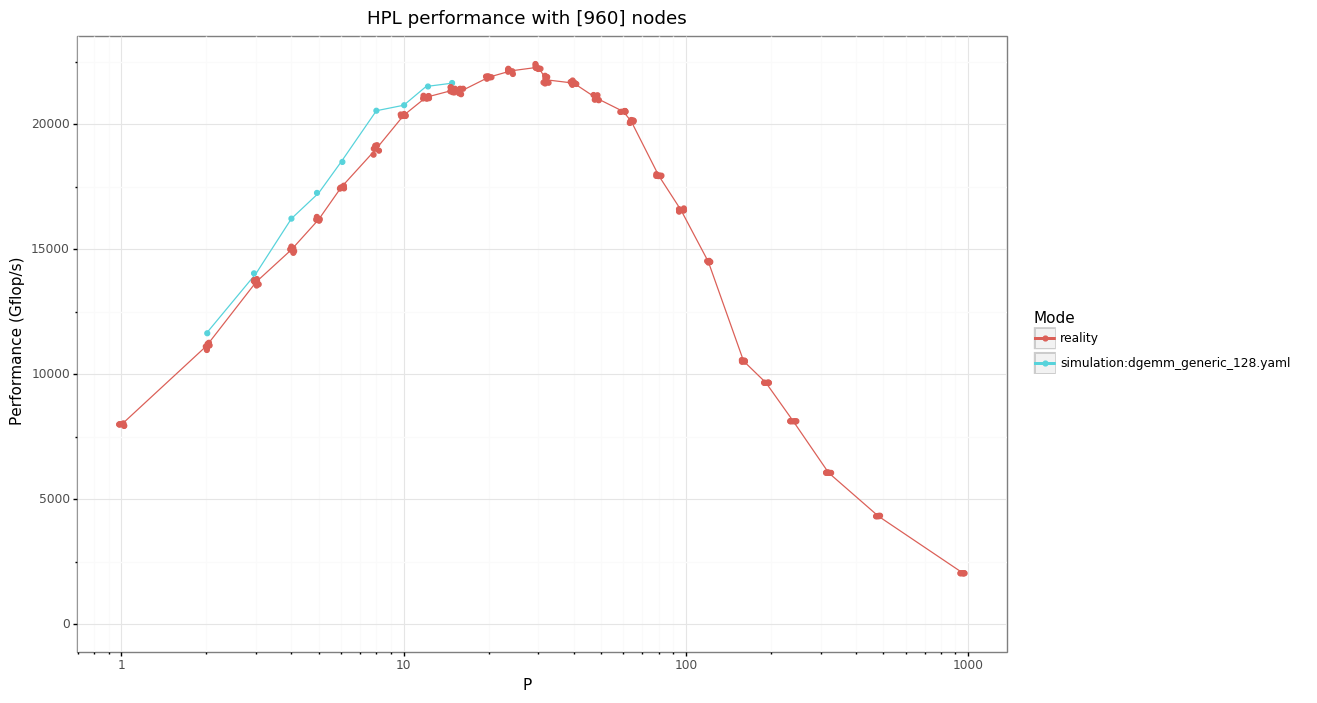

<ggplot: (8750563488253)>

In [8]:
df = df.reset_index(drop=True)
df['group'] = df['dgemm_file'].astype(str) + ':' + df['matrix_size'].astype(str) + ':' + df['mode'] + ':' + df['model'].astype(str)
df['color'] = df['mode']
df.loc[df['mode'] != 'reality', 'color'] += ':' + df['dgemm_file'].astype(str)
(ggplot(df)
    + aes(x='proc_p', y='gflops', color='color', group='group')
    + stat_summary(geom='line')
    + geom_jitter()
    + theme_bw()
    + labs(x='P', y='Performance (Gflop/s)', color='Mode')
    + expand_limits(y=0)
    + scale_x_log10()
    + ggtitle(f'HPL performance with {df["nb_nodes"].unique()} nodes')
)

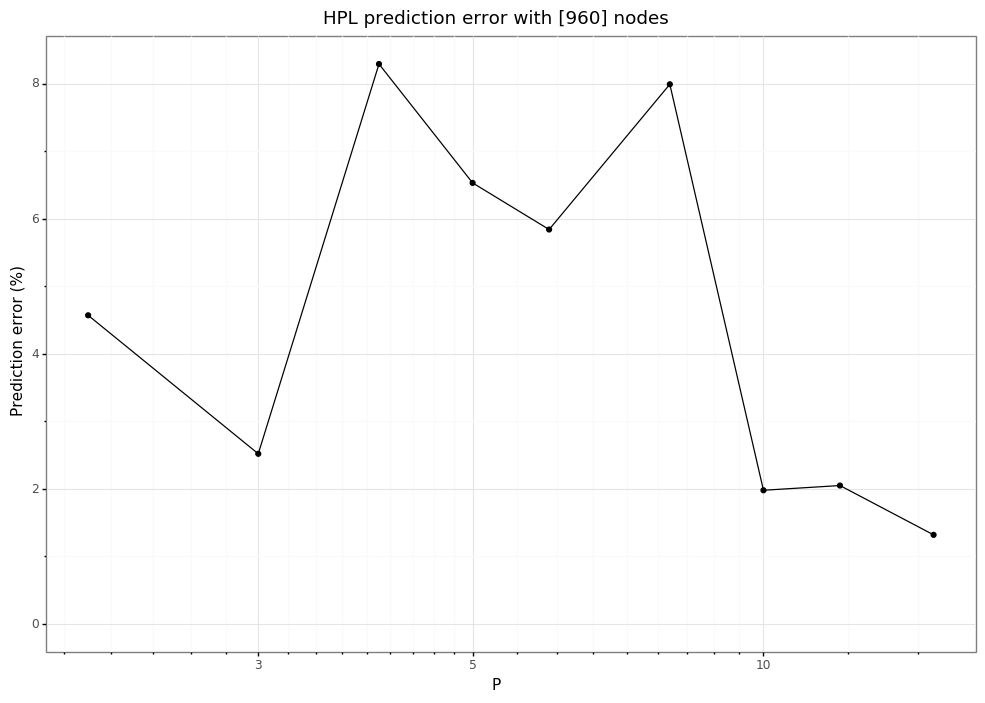

<ggplot: (8750560874283)>

In [9]:
dfsim = df[df['mode'] == 'simulation'].copy()
dfreal = df[df['mode'] == 'reality'].groupby('proc_p')[['gflops']].mean()
dfsim = dfsim.set_index('proc_p').join(dfreal, rsuffix="_real").reset_index()
dfsim['error'] = round((dfsim['gflops'] / dfsim['gflops_real'] - 1)*100, 2)

(ggplot(dfsim)
    + aes(x='proc_p', y='error')
    + stat_summary(geom='line')
    + geom_point()
    + theme_bw()
    + labs(x='P', y='Prediction error (%)')
    + expand_limits(y=0)
    + scale_x_log10()
    + ggtitle(f'HPL prediction error with {df["nb_nodes"].unique()} nodes')
)

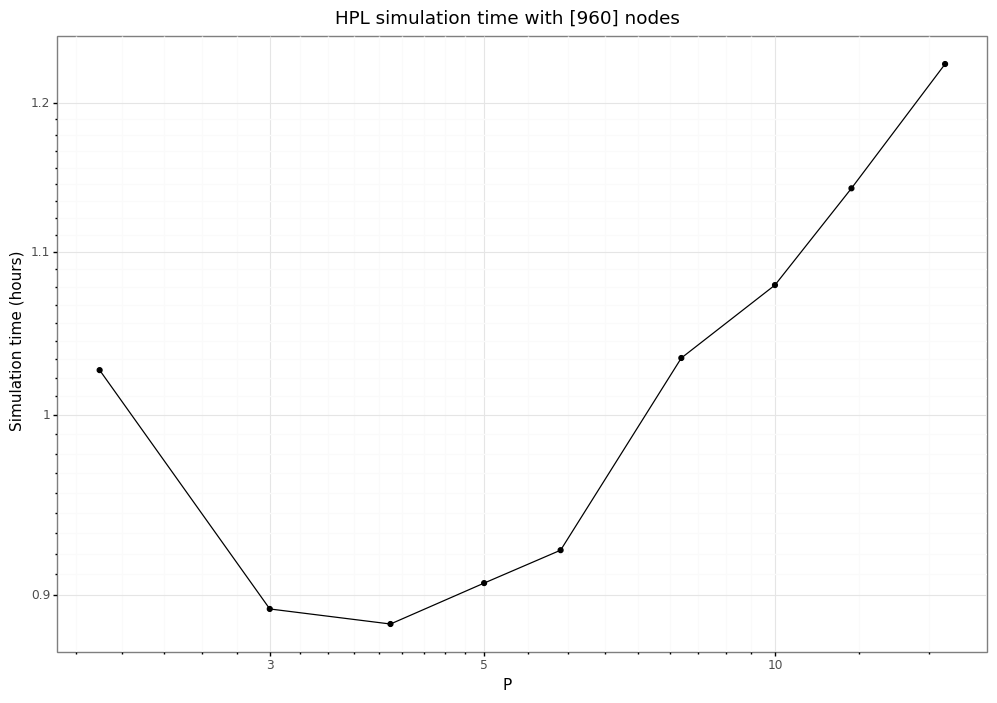

<ggplot: (-9223363286293947399)>

In [10]:
df['simtime'] = df['simulation_time'] / 3600
(ggplot(df[df['mode'] == 'simulation'])
    + aes(x='proc_p', y='simtime')
    + stat_summary(geom='line')
    + geom_point()
    + theme_bw()
    + labs(x='P', y='Simulation time (hours)')
    + expand_limits(y=0)
    + scale_x_log10()
    + scale_y_log10()
    + ggtitle(f'HPL simulation time with {df["nb_nodes"].unique()} nodes')
)

In [11]:
df['simtime'].max() / df['simtime'].min()

1.387314240878776